In [1]:
#setup
# sdir="/content/drive/My Drive/"

# import os
# from google.colab import drive
# drive.mount('/content/drive/')
# os.chdir("/content/drive/My Drive/Colab Notebooks/NLP_Project/")

import re
import numpy as np
import pandas as pd
import matplotlib.ticker as ticker
import warnings
import scipy.stats
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers import Dense, LSTM, Embedding, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from nltk.corpus import stopwords
from time import sleep
import sys
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import average_precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import r2_score
import nltk
nltk.download('stopwords')

warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nathan\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Load and Process Dataset

To-do: (DONE - averaged the columns and put them back into Valence1 and Arousal1, needed to round down the values due to labels needing to be integers)
- Average columns in spreadsheet to form a cohesive valence and arousal score
- Read in new columns

In [2]:
headers = ['Anonymized Message', 'Valence1', 'Valence2', 'Arousal1', 'Arousal2']
dtypes = {'Anonymized Message':'str', 'Valence1':'float', 'Valence2':'float', 'Arousal1':'float', 'Arousal2':'float'}
data = pd.read_csv("dataset-fb-valence-arousal-anon.csv", encoding='utf8', skiprows=[0], names=headers, dtype=dtypes, na_filter=False)
data['Valence1'] = (data.Valence1 + data.Valence2) // 2 + 1
data['Arousal1'] = (data.Arousal1 + data.Arousal2) // 2 + 1
data = data.sample(frac=1).reset_index(drop=True)

Pre-processing

In [3]:
# set all words to lowercase and remove anything that isn't a letter or space
data['Anonymized Message'] = data['Anonymized Message'].apply(lambda x: x.lower()) #transform text to lowercase
data['Anonymized Message'] = data['Anonymized Message'].apply(lambda x: re.sub('[^a-zA-z0-9\s]', '', x))

# find and remove all stop words
stop = stopwords.words('english')
data['Anonymized Message'] = data['Anonymized Message'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

Creating Model(s)

To-Do
- Define and train model for arousal (Done)
- Redefine valence model once valence columns are merged for input (Done)

In [6]:
def get_model(col):
    # setup a tokenizer to keep the most frequent 5000 words
    tokenizer = Tokenizer(num_words=6000, split=" ")
    tokenizer.fit_on_texts(data['Anonymized Message'].values)
    
    # define input X
    X = tokenizer.texts_to_sequences(data['Anonymized Message'].values)
    X = pad_sequences(X) # padding our text vector so they all have the same length
    
    # define expected output for training and testing
    y = pd.get_dummies(data[col]).values
    
    # setup and establish model with 9 outputs
    # output will be an array of length 9. 
    # the highest output value corresponds to the model's guess
    model = Sequential()
    model.add(Embedding(6000, 64, input_length=X.shape[1]))
    model.add(Dropout(0.3))
    model.add(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2))
    model.add(LSTM(264, dropout=0.3, recurrent_dropout=0.2))
    model.add(Dense(9, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    y = pd.get_dummies(data[col]).values
    
    # split X, y into training and testing 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    return model, X_train, X_test, y_train, y_test

v1_model, v1_xtrain, v1_xtest, v1_ytrain, v1_ytest = get_model('Valence1')
a1_model, a1_xtrain, a1_xtest, a1_ytrain, a1_ytest = get_model('Arousal1')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           384000    
                                                                 
 dropout_2 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_5 (LSTM)               (None, 264)               347424    
                                                                 
 dense_2 (Dense)             (None, 9)                 2385      
                                                                 
Total params: 766,833
Trainable params: 766,833
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
__________________________

Training Model(s)

To-Do:
- Train new valence and arousal models (takes about 5ish minutes per model) (Done)
- Consider if more epochs would be useful. Training would take longer but might yield better results (More epochs did not yield better results)

In [7]:
def train_model(model, X, y):
    batch_size = 4
    epochs = 8
    model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=1)
    return model

v1_model.summary()
v1_model = train_model(v1_model, v1_xtrain, v1_ytrain)
v1_model.save('valence1_analysis.h5')

a1_model.summary()
a1_model = train_model(a1_model, a1_xtrain, a1_ytrain)
a1_model.save('arousal1_analysis.h5')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 64)           384000    
                                                                 
 dropout_2 (Dropout)         (None, 100, 64)           0         
                                                                 
 lstm_4 (LSTM)               (None, 100, 64)           33024     
                                                                 
 lstm_5 (LSTM)               (None, 264)               347424    
                                                                 
 dense_2 (Dense)             (None, 9)                 2385      
                                                                 
Total params: 766,833
Trainable params: 766,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/8
579/579 [=============================

Testing Model

To-Do:
- Test new valence and arousal models (Done)

Valence1 model has an accuracy of 37.48%
Valence1 model has a correlation coefficient of 0.33
F1-score macro:  0.23021423744818953
F1-score micro:  0.3747841105354059
F1-score weighted:  0.36310263662405373
R2-score:  -0.1241476196489455


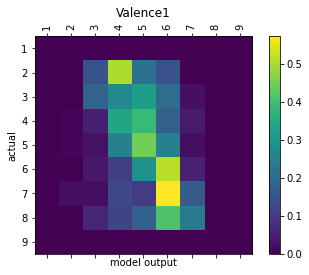

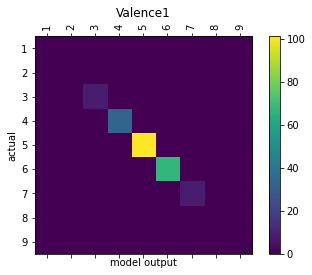

Arousal1 model has an accuracy of 26.25%
Arousal1 model has a correlation coefficient of 0.17
F1-score macro:  0.1432489290298416
F1-score micro:  0.26252158894645944
F1-score weighted:  0.2534943532124254
R2-score:  -0.4462312148274241


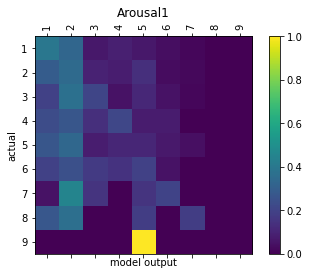

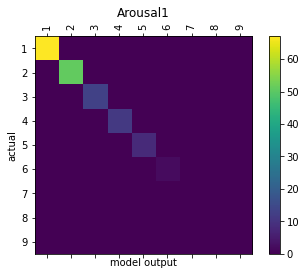

In [9]:
def test_model(col, model, X_test, y_test):
    # make predictions
    predictions = model.predict(X_test)
    
    # establish confusion matrix
    confusion = np.zeros([9,9])
    confusionA = np.zeros([9,9])
    correct = 0
    total = 0
    pred_vals = []
    actual_vals = []
    for i, prediction in enumerate(predictions):
        total += 1
        guess_i = np.argmax(prediction)
        actual_i = np.argmax(y_test[i])
        confusion[actual_i][guess_i] += 1
        if guess_i == actual_i:
            correct += 1
            confusionA[actual_i][guess_i] += 1
        pred_vals.append(guess_i + 1)
        actual_vals.append(actual_i + 1)

    # Correlation coefficient is used as a metric in the original paper
    # Our values seem to be lower than the values generated in the paper itself;
    # however, it seems that our valence r-val is generally comparable to the other
    # methods listed in table 4 of the original paper.
    r_val = scipy.stats.pearsonr(pred_vals, actual_vals)[0]
    acc = correct/total * 100

    print('%s model has an accuracy of %.2f%%' % (col, acc))
    print('%s model has a correlation coefficient of %.2f' % (col, r_val))
    print('F1-score macro: ', f1_score(actual_vals, pred_vals, average='macro'))
    print('F1-score micro: ', f1_score(actual_vals, pred_vals, average='micro'))
    print('F1-score weighted: ', f1_score(actual_vals, pred_vals, average='weighted'))
    print('R2-score: ', r2_score(actual_vals, pred_vals))
    
    # normalize confusion matrix
    for i in range(0, 9):
        sum = confusion[i].sum()
        if sum > 0:
            confusion[i] = confusion[i] / sum
       

    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion)
    fig.colorbar(cax)
    
    categories = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    ax.set_xticklabels([''] + categories, rotation=90)
    ax.set_yticklabels([''] + categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.xlabel('model output')
    plt.ylabel('actual')
    plt.title(col)
    
    plt.show()

    
    # plot results
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusionA)
    fig.colorbar(cax)
    
    categories = [1, 2, 3, 4, 5, 6, 7, 8, 9]
    ax.set_xticklabels([''] + categories, rotation=90)
    ax.set_yticklabels([''] + categories)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    
    plt.xlabel('model output')
    plt.ylabel('actual')
    plt.title(col)
    
    plt.show()
    
# make and plot predictions
test_model('Valence1', v1_model, v1_xtest, v1_ytest)
test_model('Arousal1', a1_model, a1_xtest, a1_ytest)